# Build Neurons

**Contents**


* [brainpy.NeuType](#brainpy.NeuType)
* [brainpy.NeuGroup](#brainpy.NeuGroup)
* [Reconcile the scalar- and vector-based model](#Reconcile-the-scalar--and-vector-based-model)
* [NeuType requires and NeuGroup satisfies](#NeuType-requires-and-NeuGroup-satisfies)
* [NeuType hand_overs data/func to NeuGroup](#NeuType-hand_overs-data/func-to-NeuGroup)
* [The advantages of the vector-based model](#The-advantages-of-the-vector-based-model)

In BrainPy, the *definition* and *usage* of the neuron model is separated from each other. In such a way, users can recycle the defined models to generate different neuron groups, or can use models defined by other people. Specifically, two class should be used:

- ``brainpy.NeuType``: Define the abstract neuron model.
- ``brainpy.NeuGroup``: Use the abstract neuron model to generate a concrete neuron group.

In [4]:
import sys
sys.path.append('../../')

import brainpy as bp
import numpy as np

bp.profile.set(dt=0.01)

## brainpy.NeuType

Three items should be specified to initialize a ``NeuType``:

- ``ST``: The neuronal state.
- ``name``: The neuron model name.
- ``steps``: The step functions to update at each time step.
- ``requires``: The data requires to run the defined model (optional).

Two kinds of definition provided in BrainPy to define a ``NeuType``: 

- ``scalar-based``: Each item in ``ST`` is a scalar, which represents the state of a single neuron. 
- ``vector-based``: Each item in ``ST`` is a vector, which represents the state of a group of neurons.

The definition logic of ``scalar-based`` models may be more straightforward than ``vector-based`` models. We will see this in the example of LIF model.

### Hodgkin-Huxley model

Let's first take the Hodgkin-Huxley (HH) neuron model as an example to see how to define a ``NeuType`` in BrainPy. 

In [2]:
# parameters we need # 
# ------------------ #

C = 1.0  # Membrane capacity per unit area (assumed constant).
g_Na = 120.  # Voltage-controlled conductance per unit area
             # associated with the Sodium (Na) ion-channel.
E_Na = 50.   # The equilibrium potentials for the sodium ions.
E_K = -77.   # The equilibrium potentials for the potassium ions.
g_K = 36.  # Voltage-controlled conductance per unit area
           # associated with the Potassium (K) ion-channel.
E_Leak = -54.402  # The equilibrium potentials for the potassium ions.
g_Leak = 0.003 # Conductance per unit area associated with the leak channels.
Vth = 20.  # membrane potential threshold for spike

Four differential equations exist in HH neuron model. Please check [Differential equations](https://brainpy.readthedocs.io/en/latest/advanced/differential_equations.html) to see how BrainPy supports differential equations. 

For $m$ channel, the difinition of the corresponding equations can be:

$$
\begin{align}
{\frac {dm}{dt}} &=\alpha _{m}(V)(1-m)-\beta _{m}(V)m  \\
\alpha_m(V) &= {0.1 (V+ 40) \over 1-\exp\big(-{ V+40 \over 10}\big)} \\
\beta_m(V) &= 4.0 \cdot \exp\big(-{V+65 \over 18}\big)
\end{align}
$$

In [3]:
@bp.integrate
def int_m(m, t, V):
    alpha = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta = 4.0 * np.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m
    return dmdt

The $h$ channel is defined as:

$$
\begin{align}
{\frac {dm}{dt}} &=\alpha _{m}(V)(1-m)-\beta _{m}(V)m  \\
\alpha_m(V) &= {0.1 (V+ 40) \over 1-\exp\big(-{ V+40 \over 10}\big)} \\
\beta_m(V) &= 4.0 \cdot \exp\big(-{V+65 \over 18}\big)
\end{align}
$$

In [4]:
@bp.integrate
def int_h(h, t, V):
    alpha = 0.07 * np.exp(-(V + 65) / 20.)
    beta = 1 / (1 + np.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h
    return dhdt

The $n$ channel is defined as:

$$
\begin{align}
{\frac {dn}{dt}} &=\alpha _{n}(V)(1-n)-\beta _{n}(V)n \\
\alpha_n(V) &= {0.1 \cdot (V+55) \over 1-\exp\big(-{V+55 \over10}\big)} \\
\beta_n(V) &= 0.125 \cdot \exp\big(-{V+65 \over 80}\big)
\end{align}
$$

In [5]:
@bp.integrate
def int_n(n, t, V):
    alpha = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta = 0.125 * np.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n
    return dndt

The membrane potential $V$ is defined as:

$$
\begin{align}
C_{m}{\frac {d V}{dt}}&=-{\bar {g}}_{\text{K}}n^{4}(V-V_{K}) - {\bar {g}}_{\text{Na}}m^{3}h(V-V_{Na}) -{\bar {g}}_{l}(V-V_{l}) + I_{syn}
\end{align}
$$

In [6]:
@bp.integrate
def int_V(V, t, m, h, n, Isyn):
    INa = g_Na * m ** 3 * h * (V - E_Na)
    IK = g_K * n ** 4 * (V - E_K)
    IL = g_Leak * (V - E_Leak)
    dvdt = (- INa - IK - IL + Isyn) / C
    return dvdt

In BrainPy, most of the integration of differential equations are implemented by the numerical methods, such as Euler, Exponential Euler, RK2, RK4 (please see [Numerical integrators](https://brainpy.readthedocs.io/en/latest/advanced/numerical_integrators.html)). Therefore, after defining the differential equations, the next important thing is to define the update logic for each variable from the current time point to next. 

Here, let's first define the state of a HH model. We provide a data structure ``brainpy.types.NeuState`` to support the neuron state management.

In [7]:
ST = bp.types.NeuState(
     'm',  # denotes potassium channel activation probability.
     'h',  # denotes sodium channel activation probability.
     'n',  # denotes sodium channel inactivation probability.
     'spike',  # denotes spiking state.
     'input',  # denotes synaptic input.
     V=-65.,  # denotes membrane potential.
)

In ``ST``, the dynamical variable $V$, $m$, $h$, and $n$ are inluded (without the value specification, the default value of $m$ and $n$ will be 0.). We also take care about whether the neuron provide a $spike$ at current time. Moreover, we define a $input$ item to receive the synaptic inputs and the external inputs.

Based on the neuron state ``ST``, the update logic of the HH model from the current time point ($t$) to the next time point $(t + dt)$ can be defined as:

In [8]:
def update(ST, _t):
    m = np.clip(int_m(ST['m'], _t, ST['V']), 0., 1.)
    h = np.clip(int_h(ST['h'], _t, ST['V']), 0., 1.)
    n = np.clip(int_n(ST['n'], _t, ST['V']), 0., 1.)
    V = int_V(ST['V'], _t, ST['m'], ST['h'], ST['n'], ST['input'])
    
    ST['spike'] = np.logical_and(ST['V'] < Vth, V >= Vth)
    ST['V'] = V
    ST['m'] = m
    ST['h'] = h
    ST['n'] = n
    ST['input'] = 0.

In this example, the ``update()`` function of HH model needs two data:

- ``ST``: The neuron state.
- ``_t``: The system time at current point.

Putting together, a HH neuron model is defined as:

In [9]:
HH = bp.NeuType(name='HH_neuron', 
                ST=ST, 
                steps=update,
                mode='vector')

Here, we should note that we just define an abstract HH neuron model. This model can run with any number of neurons, and with any geometry (one dimension, or two dimension). Only after define a concrete [neuron group](#brainpy.NeuGroup), can we run it or use it to construct a network.

### LIF model (vector-based)

Here, same with [HH model](#Hodgkin-Huxley-model) defined above, let's define a vector-based LIF model. The formal equations of a LIF model is given by:

$$
\tau_m \frac{dV}{dt} = - (V(t) - V_{rest}) + I(t) 
\\
\text{after}\, V(t) \gt V_{th}, V(t) =V_{rest}
\,
\text{last}\, \tau_{ref}\, \text{ms} 
$$

where $V$ is the membrane potential, $V_{rest}$ is the rest membrane potential, $V_{th}$ is the spike threshold, $\tau_m$ is the time constant, $\tau_{ref}$ is the refractory time period, and $I$ is the time-variant synaptic inputs. 

Let's define the following item in neuron state:

- ``V``: The membrane potential.
- ``input``: The synaptic input.
- ``spike``: Whether produce a spike.
- ``refractory``: Whether the neuron is in refractory state.
- ``t_last_spike``: The last spike time for calculating refractory state.

In [10]:
ST = bp.types.NeuState(
        'V',     # membrane potential
         'input',  # synaptic input
         'spike',  # spike state
         'refractory',  # refractory state
         t_last_spike=-1e7  # last spike time
    )

Assume the items in the neuron state ``ST`` of a LIF model are vectors, the update logic of vector-based LIF neuron model is:

In [11]:
tau_m=10.; Vr=0.; Vth=10.; tau_ref=0.

@bp.integrate
def int_f(V, t, Isyn):
    return (-V + Vr + Isyn) / tau_m

def update(ST, _t):
    V = int_f(ST['V'], _t, ST['input'])
    is_ref = _t - ST['t_last_spike'] < tau_ref
    V = np.where(is_ref, ST['V'], V)
    is_spike = V > Vth
    spike_idx = np.where(is_spike)[0]
    if len(spike_idx):
        V[spike_idx] = Vr
        is_ref[spike_idx] = 1.
        ST['t_last_spike'][spike_idx] = _t
    ST['V'] = V
    ST['spike'] = is_spike
    ST['refractory'] = is_ref
    ST['input'] = 0.

lif = bp.NeuType(name='LIF', 
                 ST=ST, 
                 steps=update, 
                 mode='vector')

Here, for vector-based LIF model, we must differentiate the states for each neuron at every time point. For neurons in refractory period (``is_ref``), we must keep its $V$ unchange. For neurons in spiking state (``is_spike``), we must reset its membrane potential. So, it looks like the definition of vector-based LIF mode is somewhat complex. However, the good news is that BrainPy support the difinition of neuron models in scalar mode, which means at each time point, your model difinition can only consider the behavior of one single neuron. Let's take a look.

### LIF model (scalar-based)

In [12]:
def update(ST, _t):
    if _t - ST['t_last_spike'] > tau_ref:
        V = int_f(ST['V'], _t, ST['input'])
        if V >= Vth:
            V = Vr
            ST['t_last_spike'] = _t
            ST['spike'] = True
        ST['V'] = V
    else:
        ST['spike'] = False
    ST['input'] = 0.
    
lif = bp.NeuType(name='LIF', 
                 ST=ST, 
                 steps=update, 
                 mode='scalar')

As you can see, the scalar-based LIF model is intuitive and straightforward in BrainPy. If the neuron is not in refractory period (``_t - ST['t_last_spike'] > tau_ref``), integrate the membrane potential by calling ``int_f()``. If the neuron reaches the spike threshold (``V >= Vth``), then reset the membrane potential (``V = Vr``) and set the spike state to bs ``True``. 

However, it's worthy to note that the scalar-based and the vector-based model have different flexibility ratio. The scalar-based model is convinient and easy to define, but is not flexible enough like the vector-based model. For the vector-based model, you can control everything, and define any data you want. For example, you can operate on the whole group level to count the total spikes by defining a variable `total_spike`, or get the instantaneous population firing rate, etc. Later, we will come back to this topic.

## brainpy.NeuGroup

After we talk about ``brainpy.NeuType``, the uasge of ``brainpy.NeuGroup`` is a piece of cake. This is because in a real project the most efforts we pay is the difinition of the models, and BrainPy provide a very convenient way to use your defined models. Specifically, a ``brainpy.NeuGroup`` receives the following specifications:

- ``model``: The neuron type will be used to generate a neuron group.
- ``geometry``: The geometry of the neuron group. Can be a int, or a tuple/list of int.
- ``monitors``: The items to monitor (record the history values.)
- ``name``: The neuron group name.

Let's take our defined HH model as an example.

In [14]:
group = bp.NeuGroup(HH, geometry=10, monitors=['V', 'm', 'n', 'h'])

Each group has a powerful function: ``.run()``. In this function, it receives the following arguments:

- ``duration``: Specify the simulation duration. Can be a tuple with ``(start time, end time)``. Or it can be a int to specify the duration ``length`` (then the default start time is ``0``).
- ``inputs``: Specify the inputs for each model component. With the format of ``(target, value, [operation])``. The default operation is ``+``, which means the input ``value`` will be added to the ``target``. Or, the operation can be ``-``, ``*``, ``/``, or ``=``.

In [15]:
group.run(100., inputs=('ST.input', 5.), report=True)

Compilation used 0.0000 s.
Start running ...
Run 10.0% used 0.104 s.
Run 20.0% used 0.208 s.
Run 30.0% used 0.317 s.
Run 40.0% used 0.420 s.
Run 50.0% used 0.522 s.
Run 60.0% used 0.632 s.
Run 70.0% used 0.738 s.
Run 80.0% used 0.844 s.
Run 90.0% used 0.952 s.
Run 100.0% used 1.059 s.
Simulation is done in 1.059 s.


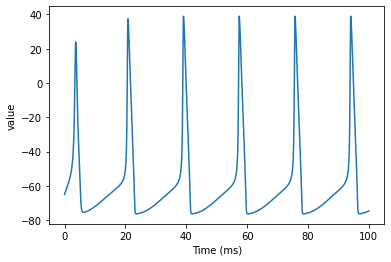

In [16]:
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

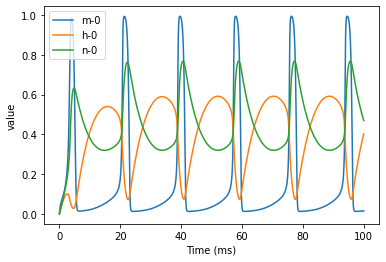

In [17]:
bp.visualize.line_plot(group.mon.ts, group.mon.m, legend='m')
bp.visualize.line_plot(group.mon.ts, group.mon.h, legend='h')
bp.visualize.line_plot(group.mon.ts, group.mon.n, legend='n', show=True)

## Reconcile the scalar- and vector-based model

The scalar-bsed and the vector-based model have different performance under different settings. When the users run the model without JIT acceleration (or ``profile.set(jit=False)``), the vector-based model is much more efficient than the scalar-based model due to the powerful array-oriented programming support in NumPy. On the contrary, the scalar-based *LIF* model sometimes is efficient than the vector-based ones in ``JIT`` mode (However, for the neuron model without too many `if .. else ...` conditions, the vector-based nueron is much more efficient, for example, the HH model). This is thanks to the JIT acceleration of for loop provided in Numba. Therefore, we recommend you to choose different difinition mode for different running backend. For example, we can define a unified LIF model with the explicit backend judgement:

In [13]:
def get_lif(tau_m=10., Vr=0., Vth=10., tau_ref=0.):
    ST = bp.types.NeuState({'V': 0, 'input':0, 'spike':0, 
                            'refractory': 0, 't_last_spike': -1e7})
    
    @bp.integrate
    def int_f(V, t, Isyn):
        return (-V + Vr + Isyn) / tau_m

    if bp.profile.is_jit():
    
        def update(ST, _t):
            if _t - ST['t_last_spike'] > tau_ref:
                V = int_f(ST['V'], _t, ST['input'])
                if V >= Vth:
                    V = Vr
                    ST['t_last_spike'] = _t
                    ST['spike'] = True
                ST['V'] = V
            else:
                ST['spike'] = False
            ST['input'] = 0.

        lif = bp.NeuType(name='LIF', ST=ST, steps=update, mode='scalar')
        
        
    else:
        
        def update(ST, _t):
            V = int_f(ST['V'], _t, ST['input'])
            is_ref = _t - ST['t_last_spike'] < tau_ref
            V = np.where(is_ref, ST['V'], V)
            is_spike = V > Vth
            spike_idx = np.where(is_spike)[0]
            if len(spike_idx):
                V[spike_idx] = Vr
                is_ref[spike_idx] = 1.
                ST['t_last_spike'][spike_idx] = _t
            ST['V'] = V
            ST['spike'] = is_spike
            ST['refractory'] = is_ref
            ST['input'] = 0.

        lif = bp.NeuType(name='LIF', ST=ST, steps=update, mode='vector')
    
    return lif

## NeuType `requires` and NeuGroup `satisfies`

The design of BrainPy is constrained by the two goals:

- JIT support. 
- The model definition and usage separation.

BrainPy heavily relies on [Numba](https://numba.pydata.org/). Unfortunately, Numba has poor support for `Python class`. And the performance of class computation is greatly reduced. In order to get the best JIT performace, BrainPy only allow users to define models by using the `Python function`. 

On the other hand, in order to recycle the defined models and hold model reproducibility, BranPy provides ``NeuType`` for model definition and ``NeuGroup`` for model usage. 

Therefore, one core feature of BrainPy is to bring the computation of a class onto the function. In a class, any data you want can be accessed by ``self.xxx``. In the function, such data ``xxx`` you **require** can be defined as an argument in ``NeuType`` step function. When using ``NeuGroup``, user must initialize the data ``xxx`` to **satisfy** the step function requires.

![](../images/class_comp_to_func.png)

Let's take the following illustrating model as an example:

In [6]:
def update(ST, _t, data1, data2):
    ...

neu = bp.NeuType('test', ST=bp.NeuState(), steps=update,
                 requires={'data1': bp.types.Array(dim=1),
                           'data2': bp.types.Array(dim=2)})

The neuron type ``neu`` *requires* `data1` (a one-dimensional array) and `data2` (a two-dimensional array) to compute its update function.

In [7]:
group = bp.NeuGroup(neu, geometry=1, 
                    satisfies={'data1': np.zeros(10), 
                               'data2':  np.ones((10, 10))})

When someone uses this defined model, he/she must provide the corresponding data (`data1` and `data2`) in the ``NeuGroup`` to *satisfy* the ``NeuType`` requirements.

However, one can also provide the required data in the following ways:

In [8]:
group = bp.NeuGroup(neu, geometry=1)
group.data1 = np.zeros(10)
group.data2 = np.ones((10, 10))

## NeuType `hand_overs` data/func to NeuGroup

Another useful keyword provided in ``NueType`` is ``hand_overs``, which means you can hand over the data or the functions defined in the ``NeuType`` to the ``NeuGroup`` when someone want to use. For example, you can define a ``init_state()`` function to initialize the HH neuron model state:

In [12]:
ST = bp.types.NeuState('V', 'm', 'h', 'n', 'spike', 'input')

@bp.integrate
def int_m(m, _t, V):
    alpha = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta = 4.0 * np.exp(-(V + 65) / 18)
    return alpha * (1 - m) - beta * m

@bp.integrate
def int_h(h, _t, V):
    alpha = 0.07 * np.exp(-(V + 65) / 20.)
    beta = 1 / (1 + np.exp(-(V + 35) / 10))
    return alpha * (1 - h) - beta * h

@bp.integrate
def int_n(n, _t, V):
    alpha = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta = 0.125 * np.exp(-(V + 65) / 80)
    return alpha * (1 - n) - beta * n

@bp.integrate
def int_V(V, _t, m, h, n, I_ext):
    I_Na = (g_Na * np.power(m, 3.0) * h) * (V - E_Na)
    I_K = (g_K * np.power(n, 4.0))* (V - E_K)
    I_leak = g_leak * (V - E_leak)
    dVdt = (- I_Na - I_K - I_leak + I_ext)/C 
    return dVdt, noise / C

# update the variables change over time (for each step)
def update(ST, _t):
    m = np.clip(int_m(ST['m'], _t, ST['V']), 0., 1.)
    h = np.clip(int_h(ST['h'], _t, ST['V']), 0., 1.)
    n = np.clip(int_n(ST['n'], _t, ST['V']), 0., 1.)
    V = int_V(ST['V'], _t, m, h, n, ST['input'])
    spike = np.logical_and(ST['V'] < V_th, V >= V_th)
    ST['spike'] = spike
    ST['V'] = V
    ST['m'] = m
    ST['h'] = h
    ST['n'] = n
    ST['input'] = 0.   

def init_state(ST, Vr):
    ST['V'] = Vr
    V = ST['V']
    
    alpha = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta = 4.0 * np.exp(-(V + 65) / 18)
    ST['m'] = alpha / (alpha + beta)
    
    alpha = 0.07 * np.exp(-(V + 65) / 20.)
    beta = 1 / (1 + np.exp(-(V + 35) / 10))
    ST['h'] = alpha / (alpha + beta)
    
    alpha = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta = 0.125 * np.exp(-(V + 65) / 80)
    ST['n'] = alpha / (alpha + beta)
    
HH_neu = bp.NeuType(name='HH_neuron', 
                    ST=ST, 
                    steps=update, 
                    mode='vector',
                    hand_overs={'init_state': init_state})

Once you use this model, you can easily initialize the model state by using:

In [15]:
HH_group = bp.NeuGroup(HH_neu, geometry=10)
HH_group.init_state(HH_group.ST, np.random.random(10) * 10 - 75.)

In [16]:
HH_group.ST['V']

array([-70.9077187 , -66.55979129, -65.14340083, -69.51226795,
       -73.38228859, -68.06085232, -72.08114256, -71.82573823,
       -71.86175207, -72.1604964 ])

In [17]:
HH_group.ST['m']

array([0.02582321, 0.04396935, 0.05204429, 0.03070063, 0.01891655,
       0.03667513, 0.02229492, 0.02302182, 0.02291798, 0.02207352])

## The advantages of the vector-based model

The advantage of the vector-based model is that you can control all the things that will happend in a neuron group. 

For example, you can define a variable ``spike_num`` to count the spike number in a neuron group.

In [18]:
tau_m=10.; Vr=0.; Vth=10.; tau_ref=0.

ST = bp.types.NeuState('V', 'input', 'spike', t_last_spike=-1e7 )

@bp.integrate
def int_f(V, t, Isyn):
    return (-V + Vr + Isyn) / tau_m

def update(ST, _t, spike_num):
    V = int_f(ST['V'], _t, ST['input'])
    is_spike = V > Vth
    spike_idx = np.where(is_spike)[0]
    num_sp = len(spike_idx)
    spike_num[0] += num_sp
    if num_sp > 0:
        V[spike_idx] = Vr
        ST['t_last_spike'][spike_idx] = _t
    ST['V'] = V
    ST['spike'] = is_spike
    ST['input'] = 0.

lif2 = bp.NeuType(name='LIF',ST=ST, steps=update, mode='vector',
                  hand_overs={'spike_num': np.array([0])})

Here, we define `spike_num` in ``update()`` function, and initialize `spike_num` as `np.array([0])` in the ``hand_overs``. In such a way, any instance of ``NeuGroup`` for such neuron type will automatically have the required data `spike_num`. Note here we use a array to get the spike number, this is because BrainPy do not support step function return (by using arrays, this problem can be easily solved).

In [19]:
group = bp.NeuGroup(lif2, geometry=10, monitors=['spike'])
group.run(100., inputs=('input', np.random.random(10) * 5 + 10.))

In [21]:
group.spike_num[0]

50

In [22]:
group.mon.spike.sum()

50.0